In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


### Load and inspect data

In [ ]:
!pip install pandas sklearn matplotlib seaborn

In [36]:
import json
from pathlib import Path
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [38]:
# data_path = Path('/content/drive/MyDrive/colab/Monoxor/requests.json') # path for .json file
data_path = Path('requests.json')
with open(data_path) as f:
    data = json.load(f)

In [4]:
n_requests = len(data)

In [5]:
a_req = data[0]

In [6]:
def get_value_of(req, f_key):
    '''
        req: dict, in which the value of a certain key is to be found
        f_key: string, key whose value is to be found
        return: value
    '''
    def f(elm):
        if type(elm) == dict:
            keys = elm.keys()
            if f_key in keys:
                return elm[f_key]
            else:
                for key in keys:
                    value = f(elm[key])
                    if value is not None:
                        return value
        
    return f(req)

In [7]:
for req in data[:5]:
    print(get_value_of(req, 'desc'), end='\n'*2)

Top recognize eat. Fact whom spend area thing material.
War no recent also message four billion. Water those deep.
Word amount table entire. Drug several the amount live newspaper.

As possible American many prepare four strong. Visit care be organization everyone kitchen development magazine. Range realize direction wife capital move.

Tuesday Notes or 2 like 2 XSP Class

State third represent energy campaign not forget there. Experience send these just heart suggest. Study paper common car kitchen it.
Such time management tree. Real like agency rule.

Us enjoy since. Time identify image position ok here best. Box can throw yeah without.
Left explain author protect throw artist lot fly. Thing year approach through miss bank.



In [8]:
values = []
for req in data:
    values.append(get_value_of(req, 'isSafe'))
print(dict(Counter(values)))

{True: 572, False: 428}


In [9]:
df = pd.DataFrame(columns=['desc', 'isSafe'], index=range(n_requests))

for i, req in enumerate(data):
    desc = get_value_of(req, 'desc')
    isSafe = get_value_of(req, 'isSafe')
    df.iloc[i, :] = desc, isSafe

In [10]:
# shuffle all records
df = df.sample(frac=1, random_state=123).reset_index(drop=True)

In [11]:
df.head()

,desc,isSafe
0,Tuesday Notes or 2 like 2 XSP Class,False
1,Huge whole take yourself throw and customer mo...,True
2,"text1<video src=1 href=1 onerror=""javascript:a...",False
3,Hotel trade need fine recognize any. Research ...,True
4,Tree measure these prove develop American.\nBe...,False


In [12]:
df.shape

(1000, 2)

### x and y

In [13]:
x = list(df['desc'].values)
y = list(df['isSafe'].values.astype('uint8')) # true->1, fasle->0

### cleaning text

In [16]:
# removing all digits and punctuations
pattern = re.compile(r'[\W\d]+')
for i in range(n_requests):
  x[i] = re.sub(pattern, ' ', x[i])

### train-val split

In [17]:
 x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.25, stratify=y, random_state=123)

In [18]:
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))

750
750
250
250


## Using TF-IDF

### prep

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1))
vectorizer.fit(x_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [21]:
x_train_vec = vectorizer.transform(x_train)
x_val_vec = vectorizer.transform(x_val)
x_train_vec, x_val_vec

(<750x993 sparse matrix of type '<class 'numpy.float64'>'
 	with 13417 stored elements in Compressed Sparse Row format>,
 <250x993 sparse matrix of type '<class 'numpy.float64'>'
 	with 4482 stored elements in Compressed Sparse Row format>)

In [22]:
print(x_train_vec.shape)
embedding_size = x_train_vec.shape[1]

(750, 993)


In [23]:
len(vectorizer.vocabulary_)

993

### Feature Selection
Chi-square test measures dependence between stochastic variables, so using this function “weeds out” the features that are the most likely to be independent of class and therefore irrelevant for classification.

In [24]:
from sklearn.feature_selection import SelectKBest, chi2

ch2 = SelectKBest(chi2, k=900)
x_train_vec_f = ch2.fit_transform(x_train_vec, y_train)
x_val_vec_f = ch2.transform(x_val_vec)

x_train_vec_f, x_val_vec_f

(<750x900 sparse matrix of type '<class 'numpy.float64'>'
 	with 12284 stored elements in Compressed Sparse Row format>,
 <250x900 sparse matrix of type '<class 'numpy.float64'>'
 	with 4055 stored elements in Compressed Sparse Row format>)

### Helper Functions

In [25]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [26]:
def show_result(y_true, y_pred, cm=True):
    print('Accuracy: ', accuracy_score(y_true, y_pred))
    if cm!=False:
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(4, 4))
        sns.heatmap(cm, annot=True, fmt='.2f');

### Logitic Regression

In [27]:
from sklearn.linear_model import LogisticRegression

In [28]:
lr = LogisticRegression()
lr.fit(x_train_vec_f, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
pred_train = lr.predict(x_train_vec_f)
pred_val = lr.predict(x_val_vec_f)

Train
Accuracy:  0.8213333333333334


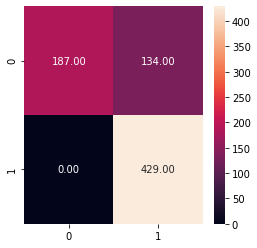

In [30]:
print('Train')
show_result(y_train, pred_train)

val
Accuracy:  0.868


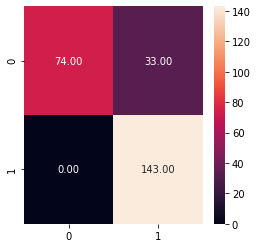

In [31]:
print('val')
show_result(y_val, pred_val, cm=True)

### What else did I try?
- GloVe embedding with LSTM - Got similar results
- Distill Bert algorithm - Got similar results